In [1]:
%matplotlib inline


Transfer Learning tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from PIL import Image
import pyexcel as pe

plt.ion()   # interactive mode

In [3]:
args_file = {
    'sequences': ['Karton_G','Kiste_G','Karton_K_pos1','Karton_K_pos2','Karton_K_pos3','Karton_K_pos4','Kiste_K_pos1','Kiste_K_pos2','Kiste_K_pos3','Kiste_K_pos4',
                  'Karton_M_pos1','Karton_M_pos2','Kiste_M_pos1','Kiste_M_pos2','Leer']   
}


class StihlData(Dataset):
    """Stihl dataset."""

    def __init__(self, ods_file, img_dir, args_file, train, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.ods_file = ods_file
        self.img_dir = img_dir
        self.args_file = args_file
        self.transform = transform
        self.train = train
        self.all_imgs, self.labels = self.get_all_images_labels(ods_file, args_file['sequences'])

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_pth = os.path.join(self.img_dir,
                                self.all_imgs[idx])
        image = Image.open(img_pth)
        image = image.convert('RGB')
        plt.imshow(image)
        label = self.labels[:,idx]
        #sample = {'image': image, 'label': label}

        if self.transform:
            image = self.transform(image)    
        
        image = np.array(image)

        return image,label
    
    def get_all_images_labels(self, ods_file, sequences):
        imgs = []
        labels = [[] for i in range(4)]

        for sequence in sequences:
            data1 = pe.get_dict(file_name=ods_file,sheets=[sequence])       
            
            ix = [i for i, e in enumerate(data1['train']) if e == self.train]

            imgs.append([data1['Images'][i] for i in ix])
            labels[0].append([data1['q1'][i] for i in ix])
            labels[1].append([data1['q2'][i] for i in ix])
            labels[2].append([data1['q3'][i] for i in ix])
            labels[3].append([data1['q4'][i] for i in ix])
    
        all_imgs = [item for sublist in imgs for item in sublist]
        labels[0] = [item for sublist in labels[0] for item in sublist]
        labels[1] = [item for sublist in labels[1] for item in sublist]
        labels[2] = [item for sublist in labels[2] for item in sublist]
        labels[3] = [item for sublist in labels[3] for item in sublist]
        labels_np = np.array([labels[0],labels[1],labels[2],labels[3]])
        return all_imgs, labels_np

In [4]:
img_root = '/home/ron/PycharmProjects/tuts/stihl_data/imgs'
annotation_file = '/home/ron/PycharmProjects/tuts/annotations/annotations_stihldata_final_train_test.ods'

# mean and std values:
m1 = 0.337065
m2 = 0.246142
m3 = 0.350733
std1 = 0.186628
std2 = 0.155537
std3 = 0.168538

transform=transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([m1, m2, m3], [std1, std2, std3])
    ])

img_dataset={}
img_dataset['train'] = StihlData(annotation_file, img_root, args_file, 1, transform)
img_dataset['val'] = StihlData(annotation_file, img_root, args_file, 0, transform)

In [5]:
dataloaders={}

dataloaders['train'] = torch.utils.data.DataLoader(img_dataset['train'], batch_size=4,
                                             shuffle=True, num_workers=4)

dataloaders['val'] = torch.utils.data.DataLoader(img_dataset['val'], batch_size=4,
                                             shuffle=True, num_workers=4)

In [6]:
dataset_sizes = {x: len(img_dataset[x]) for x in ['train', 'val']}


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

tensor([[ 3,  3,  3,  3],
        [ 5,  5,  5,  5],
        [ 3,  3,  3,  3],
        [ 4,  4,  4,  4]])


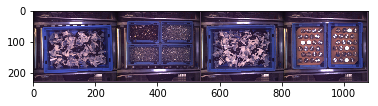

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([m1, m2, m3])
    std = np.array([std1, std2, std3])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, labels = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

print(labels)
imshow(out)

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                #labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs1, outputs2, outputs3, outputs4 = model(inputs)
                    
                    loss = 0

                    _, preds1 = torch.max(outputs1, 1)                   
                    lbl1 = labels[:,0]
                    #print(lbl1)
                    lbl1 = lbl1.to(device)
                    loss += criterion(outputs1, lbl1)
                    
                    
                    _, preds2 = torch.max(outputs2, 1) 
                    lbl2 = labels[:,1]
                    lbl2 = lbl2.to(device)
                    loss += criterion(outputs2, lbl2)
                    
                    
                    _, preds3 = torch.max(outputs3, 1)
                    lbl3 = labels[:,2]
                    lbl3 = lbl3.to(device)
                    loss += criterion(outputs3, lbl3)


                    _, preds4 = torch.max(outputs4, 1)                    
                    lbl4 = labels[:,3]
                    lbl4 = lbl4.to(device)
                    loss += criterion(outputs4, lbl4)
                    

                    
                    #loss = sum(loss_partial)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0) * 4 #times 4  because there is one output for each quadrant
                running_corrects += torch.sum(preds1 == lbl1.data) + torch.sum(preds2 == lbl2.data) + torch.sum(preds3 == lbl3.data) + torch.sum(preds4 == lbl4.data)
                               
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [15]:
pretrained_model = models.resnet18(pretrained=True)
pretrained_model_ft = nn.Sequential(*list(pretrained_model.children())[:-1]) #remove FC layer

class MyNet(nn.Module):
    #constructor
    def __init__(self,pretrained_model,ft_out,no_classes):
        super(MyNet, self).__init__()
        #defining layers in convnet
        self.ft_out = ft_out
        self.no_classes = no_classes
        self.pretrained_model = pretrained_model
        self.fc1 = nn.Linear(ft_out, no_classes*4) # because of 4 quadrants 

    def forward(self, x):
        x=self.pretrained_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = x.view(-1,self.no_classes,4)
        
        x1 = x[:,:,0]
        x2 = x[:,:,1]
        x3 = x[:,:,2]
        x4 = x[:,:,3]
        
        return x1, x2, x3, x4
        
        
model_ft = MyNet(pretrained_model_ft, 1536, 7)

In [16]:
#pretrained_model = models.resnet18(pretrained=True)
#num_ftrs = model_ft.fc.in_features
#num_ftrs = 1536
#num_classes = 6
#model_ft.fc = nn.Linear(num_ftrs, num_classes)

#model_ft= nn.Sequential(*list(pretrained_model.children())[:-1]) #remove FC layer


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
print(model_ft)

MyNet(
  (pretrained_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------


Process Process-8:
Process Process-5:
Traceback (most recent call last):
  File "/home/ron/anaconda3/envs/gait_36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-6:
  File "/home/ron/anaconda3/envs/gait_36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ron/anaconda3/envs/gait_36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
Process Process-7:
  File "/home/ron/anaconda3/envs/gait_36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-3-a2ea8e21848c>", line 32, in __getitem__
    image = image.convert('RGB')
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ron/anaconda3/envs/gait_36/lib/python3.6/site-packages/PIL/Ima

KeyboardInterrupt: 

In [ ]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()